<a href="https://colab.research.google.com/github/Lexie-v2/Goggle-CO/blob/main/Proyecto_IA_Predicci%C3%B3n_de_Precipitaci%C3%B3n_Horaria_en_Trujillo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#I. Subida y Carga de los Datos

#### I.1. Instalar las librerías necesarias

In [1]:
!pip install xarray netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.1 MB/s eta 0:00:00


#### I.2. Importamos las librerías necesarias

In [2]:
#from google.colab import files
import xarray as xr
import pandas as pd
import numpy as np
from google.colab import drive
import zipfile
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

#### I.3. Subida de archivos

In [3]:
#uploaded = files.upload()
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/17148401.zip'
extract_to = '/content/17148401'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

Mounted at /content/drive


#### I.4. Guardar el nombre de los archivos

In [4]:
archivos_nc = [os.path.join(extract_to, f) for f in os.listdir(extract_to) if f.endswith('.nc')]
archivos_nc.sort()
print(f"Archivos detectados: {archivos_nc}")

Archivos detectados: ['/content/17148401/PISCOp_h_2015.nc', '/content/17148401/PISCOp_h_2016.nc', '/content/17148401/PISCOp_h_2017.nc', '/content/17148401/PISCOp_h_2018.nc', '/content/17148401/PISCOp_h_2019.nc', '/content/17148401/PISCOp_h_2020.nc']


#### I.5. Cargamos los archivos e identificamos las coordenadas de Trujillo

In [5]:
ds = xr.open_mfdataset(archivos_nc, combine='by_coords', engine='netcdf4')
lat_trujillo = -8.11
lon_trujillo = -79.03

#### I.6. Extraer la serie de tiempo más cercana

In [6]:
serie_trujillo = ds['p'].sel(latitude=lat_trujillo, longitude=lon_trujillo, method='nearest').to_series().sort_index()

#### I.7. Mostramos las primeras filas

In [7]:
print(serie_trujillo.head())

time
2015-01-01 00:00:00    0.0
2015-01-01 01:00:00    0.2
2015-01-01 02:00:00    0.0
2015-01-01 03:00:00    0.4
2015-01-01 04:00:00    0.0
Name: p, dtype: float32


#II. Elaboración del Dataset

#### II.1. Creamos el dataset supervisado

In [8]:
n_lags = 24  #Agregamos el número de horas anteriores como entrada
X, y = [], []
valores = serie_trujillo.values

for i in range(n_lags, len(valores)):
    X.append(valores[i - n_lags:i])
    y.append(valores[i])

X = np.array(X)
y = np.array(y)

#### II.2. Proceso de Normalización

In [9]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

#### II.3. División del Dataset en entrenamiento y prueba

In [10]:
##Se usará un 80% para entrenamiento y el 20% restante para prueba
n_total = X_scaled.shape[0]
n_entrenamiento = int(n_total * 0.8)

X_train = X_scaled[:n_entrenamiento]
y_train = y_scaled[:n_entrenamiento]
X_test  = X_scaled[n_entrenamiento:]
y_test  = y_scaled[n_entrenamiento:]

#III. Enternamiento y Validación del Modelo

#### III.1. Validación por TimeSeriesSplit (Validación Cruzada para Series Temporales)

In [11]:
tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_index, val_index) in enumerate(tscv.split(X_train)):
    X_t, X_val = X_train[train_index], X_train[val_index]
    y_t, y_val = y_train[train_index], y_train[val_index]

#### III.2. Entrenamiento del Modelo (Random Forest)

In [12]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_t, y_t)

RandomForestRegressor(random_state=42)

# IV. Predicciones y Evaluación

#### IV.1. Predicción

In [13]:
y_pred = model.predict(X_val)

#Para poder interpretar los resultados en mm/h se debe invertir la normalización
y_val_real = scaler_y.inverse_transform(y_val.reshape(-1, 1)).ravel()
y_pred_real = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()

#### IV.2. Evaluación

In [14]:
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

#### IV.3. Resultados

In [15]:
print(f"\nEvaluación del modelo:")
print(f"- Error Cuadrático Medio (MSE): {mse:.3f} mm²/h²")
print(f"- Coeficiente R²: {r2:.3f} (0 a 1)")

if mse < 0.1:
    calidad = "Excelente"
elif mse < 0.5:
    calidad = "Buena"
elif mse < 1.0:
    calidad = "Aceptable"
else:
    calidad = "Baja" #posibles picos no detectados"

print(f"Precisión: {calidad}")


Evaluación del modelo:
- Error Cuadrático Medio (MSE): 0.001 mm²/h²
- Coeficiente R²: -0.033 (0 a 1)
Precisión: Excelente


#### IV.4. Predicción en Contexto (Predicción vs Valor Real)

In [16]:
print("\nPredicción vs. valor real:")
for i in range(5):
    real = y_val_real[i]
    pred = y_pred_real[i]
    print(f"- Hora {i+1}: Real = {real:.2f} mm/h, Predicho = {pred:.2f} mm/h")


Predicción vs. valor real:
- Hora 1: Real = 0.00 mm/h, Predicho = 0.01 mm/h
- Hora 2: Real = 0.00 mm/h, Predicho = 0.01 mm/h
- Hora 3: Real = 0.00 mm/h, Predicho = 0.01 mm/h
- Hora 4: Real = 0.00 mm/h, Predicho = 0.01 mm/h
- Hora 5: Real = 0.00 mm/h, Predicho = 0.01 mm/h


#### IV.5. Visualización Gráfica de Resultados

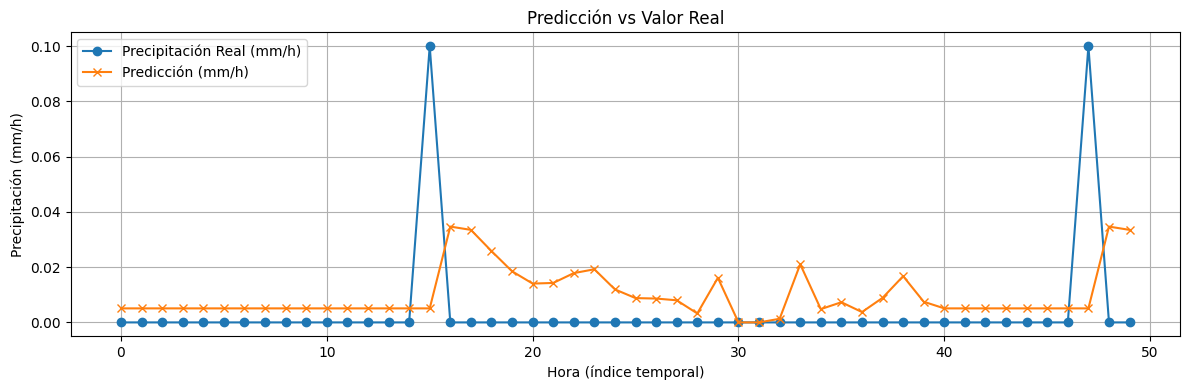

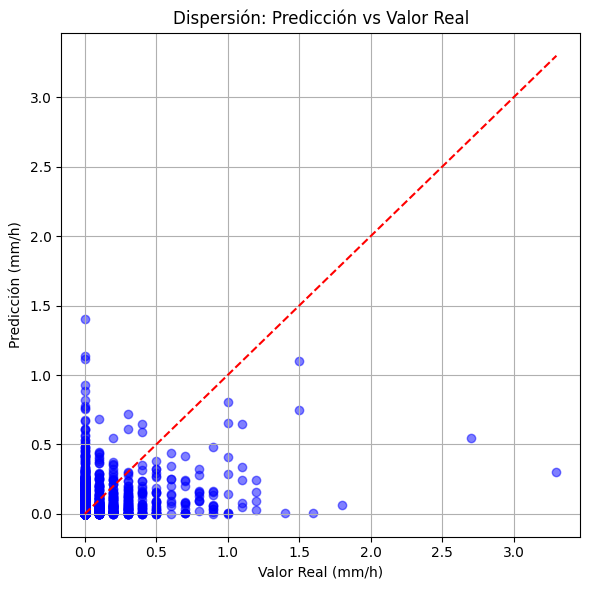

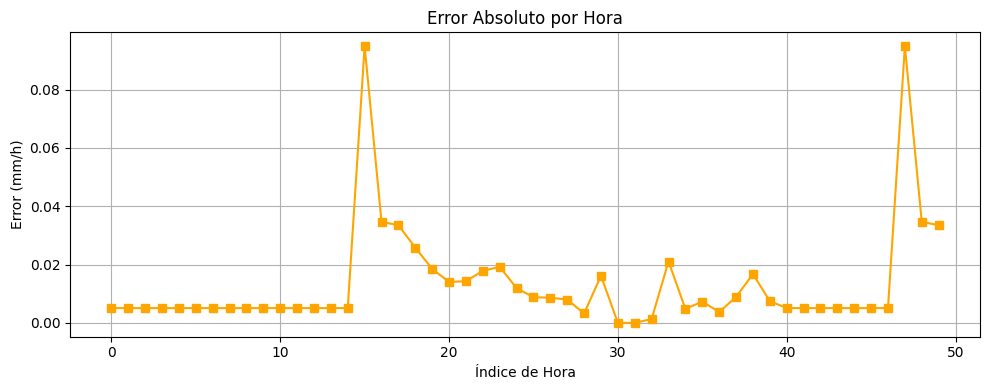

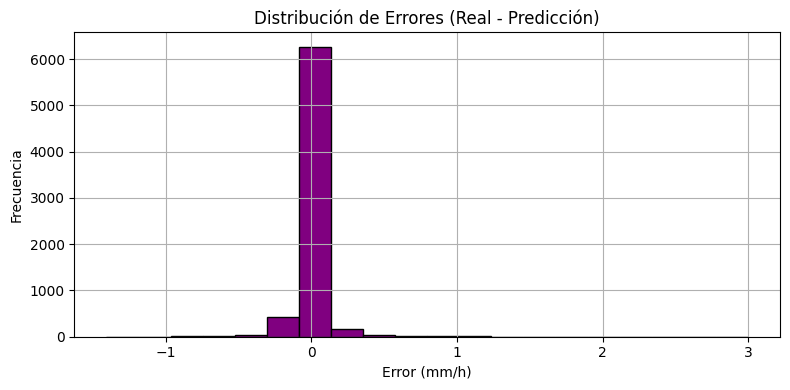

In [17]:
#Visualización de la Predicción en Contexto (Gráfico de Líneas)
plt.figure(figsize=(12, 4))
plt.plot(y_val_real[:50], label='Precipitación Real (mm/h)', marker='o')
plt.plot(y_pred_real[:50], label='Predicción (mm/h)', marker='x')
plt.title(f'Predicción vs Valor Real')
plt.xlabel('Hora (índice temporal)')
plt.ylabel('Precipitación (mm/h)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Visualización de la Predicción en Contexto (Diagrama de Dispersión o Scatter Plot)
plt.figure(figsize=(6, 6))
plt.scatter(y_val_real, y_pred_real, alpha=0.5, c='blue')
plt.plot([0, max(y_val_real)], [0, max(y_val_real)], 'r--')#línea ideal
plt.xlabel('Valor Real (mm/h)')
plt.ylabel('Predicción (mm/h)')
plt.title('Dispersión: Predicción vs Valor Real')
plt.grid(True)
plt.tight_layout()
plt.show()

#Visualización de la Predicción en Contexto (Gráfico de Error Absoluto)
error_abs = np.abs(y_val_real - y_pred_real)
plt.figure(figsize=(10, 4))
plt.plot(error_abs[:50], color='orange', marker='s')
plt.title('Error Absoluto por Hora')
plt.xlabel('Índice de Hora')
plt.ylabel('Error (mm/h)')
plt.grid(True)
plt.tight_layout()
plt.show()

#Visualización de la Predicción en Contexto (Histograma de Errores)
errores = y_val_real - y_pred_real
plt.figure(figsize=(8, 4))
plt.hist(errores, bins=20, color='purple', edgecolor='black')
plt.title('Distribución de Errores (Real - Predicción)')
plt.xlabel('Error (mm/h)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
import pickle
with open("scaler_X.pkl","wb") as f: pickle.dump(scaler_X, f)
with open("scaler_y.pkl","wb") as f: pickle.dump(scaler_y, f)
with open("rf_model.pkl","wb") as f: pickle.dump(model, f)